# Practice 7 - Intelligent Systems

### Omar Christian Arias Chavez

The objetive for this practice is to create a system that can predict what kind of star is, using some data like:
<ul>
    <li>Temperature</li>
    <li>L: Relative Luminosity</li>
    <li>R: Relative Radius</li>
    <li>AM: Absolute Magnitude</li>
    <li>Color: General Color of Spectrum</li>
    <li>Spectral_Class: O,B,A,F,G,K,M</li>
</ul>


There are 6 types of stars that the system can predict:

<ul>
    <li>Red Dwarf - 0</li>
    <li>Brown Dwarf - 1</li>
    <li>White Dwarf - 2</li>
    <li>Main Sequence - 3</li>
    <li>Super Giants - 4</li>
    <li>Hyper Giants - 5</li>
</ul>
 
Representing them with numbers from 0 to 5, in the same order as the previous list.



These are the libraries that were used, mainly "keras" and "tensorflow" that are focused in machine learning. 
And "pandas" to take the trining file like a dataframe.

In [127]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from numpy.random import seed
from numpy import array
from numpy import argmax
from keras import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

It was established a seed on 10, to have the same results if we use a ramdon. 

Here the trining file was read, as a dataframe. And shows the first 10 rows.
Here we detected two problems. 

First, there are two columns with string data, and the second problem is that one of them, has some mistakes in her data.


In [128]:
seed(10)
# read dataset
csv_file = 'assignment_ds.csv'
df = pd.read_csv(csv_file)
df[0:10]

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,Red,M,0
1,12098,689.000000,7.0100,0.02,Blue-white,A,3
2,2731,0.000437,0.0856,18.09,Red,M,0
3,37800,202900.000000,6.8600,-4.56,Blue,O,3
4,8570,0.000810,0.0097,14.20,Blue white,A,2
5,3605,126000.000000,1124.0000,-10.81,Red,M,5
6,8052,8.700000,1.8000,2.42,Whitish,A,3
7,3574,200000.000000,89.0000,-5.24,Red,M,4
8,8829,537493.000000,1423.0000,-10.73,White,A,5
9,3625,74000.000000,876.0000,-10.25,Red,M,5


## Normalize Data

First we show how many colums and rows there are, so we have 7 colums, where 6 of them there will be our Inputs, and the last one is going to be our output.

And now we can see the values of the two colums, there are two especific cases where we could have problems, in the colors "Blue White", where we have the cases: "Blue-white", "Blue white", "Blue White" and "Blue-White".
And the second case is in the color "Yellow White", with the cases: "yellow-white" and "White-Yellow".


In [129]:
print(df.shape)
print(df['Color'].unique())
print(df['Spectral_Class'].unique())

(200, 7)
['Red' 'Blue-white' 'Blue' 'Blue white' 'Whitish' 'White' 'Blue White'
 'yellowish' 'white' 'yellow-white' 'Yellowish White' 'Orange'
 'White-Yellow' 'Pale yellow orange' 'Orange-Red' 'Blue-White' 'Yellowish']
['M' 'A' 'O' 'B' 'K' 'F' 'G']


So to fix the problem with uppercase and lowercase, all letters will be converted to uppercase.

Then it make a "map" to fix both problems, replacing colors with numbers. So the dataframe and the inputs only will have numeric inputs, and it will be possible to proceed with the creation of the neural network.

The are a function that can convert word into numbers to, but make a change with "map" looks easier, and with an undocumented test, it showed problems.

After some test, it was observed that affects the number that we put in the 'Color' column and the 'Spectral_Class' column. 
I started by sorting the colors with the numbers of the 0 at 10, but it shows less precision. It happened in the same way with the column 'Spectral_Class'. 

I tried to sorting the colors with the numbers of the 10 at 110, but it looks worse. So I decided to leave as I did with my first try

In [130]:
df.Color = df["Color"].str.upper()

df['Color'] = df['Color'].map({'RED':1,
                             'BLUE-WHITE':2,
                             'BLUE WHITE':2,
                             'BLUE':3,
                             'WHITISH':4,
                             'WHITE':5,
                             'YELLOWISH':6,
                             'YELLOW-WHITE':7,
                             'WHITE-YELLOW':7,
                             'YELLOWISH WHITE':8,
                             'ORANGE':9,
                             'PALE YELLOW ORANGE':10,
                             'ORANGE-RED':11},
                             na_action=None)

df['Spectral_Class'] = df['Spectral_Class'].map({'M':1,
                             'A':2,
                             'O':3,
                             'B':4,
                             'K':5,
                             'F':6,
                             'G':7},
                             na_action=None)

print(df)


     Temperature              L         R    A_M  Color  Spectral_Class  Type
0           3453       0.000621   0.07730  17.08      1               1     0
1          12098     689.000000   7.01000   0.02      2               2     3
2           2731       0.000437   0.08560  18.09      1               1     0
3          37800  202900.000000   6.86000  -4.56      3               3     3
4           8570       0.000810   0.00970  14.20      2               2     2
..           ...            ...       ...    ...    ...             ...   ...
195        13420       0.000590   0.00981  13.67      2               4     2
196        19860       0.001100   0.01310  11.34      3               4     2
197        13023     998.000000   6.21000  -1.38      2               2     3
198        39000  204000.000000  10.60000  -4.70      3               3     3
199        12010       0.000780   0.00920  12.13      2               4     2

[200 rows x 7 columns]


Save the inputs columns into the variable "inputs", and the output column into the variable "target".

In [134]:
# get inputs - outputs
inputs = df[['Temperature','L','R','A_M','Color','Spectral_Class']]
target = df [['Type']]

df_train = df

df_inputs = inputs
df_outputs = target

Transform all the numbers from the inputs into a number between 0 and 1. 


In [89]:
# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs

,0,1,2,3,4,5
0,0.039778,6.369052e-10,3.536069e-05,0.906817,0.0,0.000000
1,0.266914,8.111416e-04,3.593344e-03,0.373358,0.1,0.166667
2,0.020809,4.202868e-10,3.962039e-05,0.938399,0.0,0.000000
3,0.942198,2.388689e-01,3.516361e-03,0.230144,0.2,0.333333
4,0.174220,8.594100e-10,6.671828e-07,0.816760,0.1,0.166667
...,...,...,...,...,...,...
195,0.301647,6.004097e-10,7.236367e-07,0.800188,0.1,0.500000
196,0.470849,1.200819e-09,2.412122e-06,0.727330,0.2,0.500000
197,0.291217,1.174919e-03,3.182770e-03,0.329581,0.1,0.166667
198,0.973726,2.401639e-01,5.435795e-03,0.225766,0.2,0.333333


In [90]:
target.head()

,Type
0,0
1,3
2,0
3,3
4,2


In [91]:

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(target)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
target = pd.DataFrame(onehot_encoded)

target.head()

D:\Anaconda\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
D:\Anaconda\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


## Split Training Set from Validation Set

In [92]:
# define training dataset size
ds_size = inputs.shape[0]
train_size_percentage = .7
test_size_percentage = .2

training_size = int(ds_size * train_size_percentage)
test_size = int(ds_size * test_size_percentage)

# get training data
input_training = inputs[:training_size]
target_training = target[:training_size]

# get test data
input_test = inputs[training_size:(training_size + test_size)]
target_test = target[training_size:(training_size + test_size)]

# get validation data
input_validation = inputs[(training_size + test_size):]
target_validation = target[(training_size + test_size):]

# used during training
print('Training DS size:', input_training.shape[0])
print('Test DS size:', input_test.shape[0])

# used during validation
print('Validation DS size', input_validation.shape[0])

Training DS size: 140
Test DS size: 40
Validation DS size 20


In [93]:
print('inputs:')
print(inputs[:10])
print('target')
target[:10]

inputs:
          0             1             2         3    4         5
0  0.039778  6.369052e-10  3.536069e-05  0.906817  0.0  0.000000
1  0.266914  8.111416e-04  3.593344e-03  0.373358  0.1  0.166667
2  0.020809  4.202868e-10  3.962039e-05  0.938399  0.0  0.000000
3  0.942198  2.388689e-01  3.516361e-03  0.230144  0.2  0.333333
4  0.174220  8.594100e-10  6.671828e-07  0.816760  0.1  0.166667
5  0.043772  1.483365e-01  5.768522e-01  0.034709  0.0  0.000000
6  0.160611  1.024219e-05  9.194805e-04  0.448405  0.3  0.166667
7  0.042957  2.354548e-01  4.567205e-02  0.208881  0.0  0.000000
8  0.181025  6.327765e-01  7.303042e-01  0.037211  0.4  0.166667
9  0.044297  8.711827e-02  4.495742e-01  0.052220  0.0  0.000000
target


,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,1.0


## Train Neural Network

It creates a neural network, with a input layer with 6 inputs, and a next layer with 64 neurons with the actiavion method of "relu".

Then, it creates another hidden layer with 32 neurons, and with an actiavion method of "sigmoid".

Finally the output layer has 6 possibilities.

So the neural network has 4 layers, with 2 hidden layers. 

The first test has the same actiavion method of "relu", but the results were not very satisfactory, and tried add neurons, but was worse. So i looked for another actiavion methods, and find "sigmoid". With a simple test it return a perfect result.

In [94]:

# neural network
model = models.Sequential()

# input layer
model.add(layers.Dense(64, activation='relu', input_shape=(6,)))

# hidden layers
model.add(layers.Dense(32, activation='sigmoid'))

# output layers
model.add(layers.Dense(6))
    
rmsprop = optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=rmsprop, loss='mse', metrics=[metrics.categorical_accuracy])

The results looks very good, it has 1000 epochs to train. And it get a tegorical accuracy of 0.9250, but the previous epoch has 1.00, and the loss gets very low in the epoch 993. 

So looks like it has a good result. 

In [95]:
num_epochs = 1000
batch_size = 64

history = model.fit(input_training, target_training,
                            validation_data=(input_test, target_test),
                            epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/1000
3/3 [==============================] - 1s 70ms/step - loss: 7.0413 - categorical_accuracy: 0.1286 - val_loss: 0.1511 - val_categorical_accuracy: 0.1250
Epoch 2/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.1550 - categorical_accuracy: 0.2286 - val_loss: 0.1338 - val_categorical_accuracy: 0.2250
Epoch 3/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.1252 - categorical_accuracy: 0.3500 - val_loss: 0.1190 - val_categorical_accuracy: 0.4500
Epoch 4/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.1197 - categorical_accuracy: 0.4357 - val_loss: 0.1132 - val_categorical_accuracy: 0.3000
Epoch 5/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.1103 - categorical_accuracy: 0.4429 - val_loss: 0.1233 - val_categorical_accuracy: 0.5500
Epoch 6/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.1286 - categorical_accuracy: 0.3643 - val_loss: 0.1096 - val_categorical_accuracy: 0.4000
Epoch 7/100

3/3 [==============================] - 0s 11ms/step - loss: 0.0573 - categorical_accuracy: 0.7429 - val_loss: 0.0794 - val_categorical_accuracy: 0.6750
Epoch 51/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0755 - categorical_accuracy: 0.6786 - val_loss: 0.0612 - val_categorical_accuracy: 0.7000
Epoch 52/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0522 - categorical_accuracy: 0.7929 - val_loss: 0.0769 - val_categorical_accuracy: 0.8000
Epoch 53/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0671 - categorical_accuracy: 0.7643 - val_loss: 0.0449 - val_categorical_accuracy: 0.7750
Epoch 54/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0421 - categorical_accuracy: 0.8143 - val_loss: 0.0387 - val_categorical_accuracy: 0.8750
Epoch 55/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0455 - categorical_accuracy: 0.8143 - val_loss: 0.0740 - val_categorical_accuracy: 0.7500
Epoch 56/1000
3/3 [=

3/3 [==============================] - 0s 11ms/step - loss: 0.0463 - categorical_accuracy: 0.9071 - val_loss: 0.0229 - val_categorical_accuracy: 0.9750
Epoch 100/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0223 - categorical_accuracy: 0.9714 - val_loss: 0.0767 - val_categorical_accuracy: 0.8000
Epoch 101/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0386 - categorical_accuracy: 0.9000 - val_loss: 0.0138 - val_categorical_accuracy: 1.0000
Epoch 102/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0126 - categorical_accuracy: 0.9929 - val_loss: 0.0245 - val_categorical_accuracy: 0.9250
Epoch 103/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0273 - categorical_accuracy: 0.9071 - val_loss: 0.0514 - val_categorical_accuracy: 0.8250
Epoch 104/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0715 - categorical_accuracy: 0.8214 - val_loss: 0.0735 - val_categorical_accuracy: 0.8500
Epoch 105/100

Epoch 148/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0189 - categorical_accuracy: 0.9929 - val_loss: 0.0240 - val_categorical_accuracy: 0.9750
Epoch 149/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0195 - categorical_accuracy: 0.9857 - val_loss: 0.0559 - val_categorical_accuracy: 0.8500
Epoch 150/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0349 - categorical_accuracy: 0.9357 - val_loss: 0.0492 - val_categorical_accuracy: 0.9000
Epoch 151/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0466 - categorical_accuracy: 0.9214 - val_loss: 0.0165 - val_categorical_accuracy: 0.9750
Epoch 152/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0124 - categorical_accuracy: 0.9929 - val_loss: 0.0092 - val_categorical_accuracy: 1.0000
Epoch 153/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0083 - categorical_accuracy: 1.0000 - val_loss: 0.0250 - val_categorical_accuracy: 1.0000


Epoch 197/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0269 - categorical_accuracy: 0.9643 - val_loss: 0.0374 - val_categorical_accuracy: 0.9750
Epoch 198/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0277 - categorical_accuracy: 0.9929 - val_loss: 0.0474 - val_categorical_accuracy: 1.0000
Epoch 199/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0974 - categorical_accuracy: 0.9071 - val_loss: 0.0467 - val_categorical_accuracy: 1.0000
Epoch 200/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0323 - categorical_accuracy: 1.0000 - val_loss: 0.0088 - val_categorical_accuracy: 1.0000
Epoch 201/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0063 - categorical_accuracy: 1.0000 - val_loss: 0.0083 - val_categorical_accuracy: 0.9750
Epoch 202/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0121 - categorical_accuracy: 0.9643 - val_loss: 0.0155 - val_categorical_accuracy: 1.000

Epoch 246/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0256 - categorical_accuracy: 0.9643 - val_loss: 0.1698 - val_categorical_accuracy: 0.7500
Epoch 247/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.1024 - categorical_accuracy: 0.8214 - val_loss: 0.0736 - val_categorical_accuracy: 0.8000
Epoch 248/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0459 - categorical_accuracy: 0.9143 - val_loss: 0.0442 - val_categorical_accuracy: 0.8500
Epoch 249/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0168 - categorical_accuracy: 0.9714 - val_loss: 0.0123 - val_categorical_accuracy: 1.0000
Epoch 250/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0079 - categorical_accuracy: 1.0000 - val_loss: 0.0383 - val_categorical_accuracy: 0.9750
Epoch 251/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0287 - categorical_accuracy: 0.9786 - val_loss: 0.0318 - val_categorical_accuracy: 0.950

Epoch 295/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0166 - categorical_accuracy: 0.9571 - val_loss: 0.0269 - val_categorical_accuracy: 0.9750
Epoch 296/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0199 - categorical_accuracy: 0.9929 - val_loss: 0.0301 - val_categorical_accuracy: 0.9750
Epoch 297/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0301 - categorical_accuracy: 0.9929 - val_loss: 0.0208 - val_categorical_accuracy: 1.0000
Epoch 298/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0225 - categorical_accuracy: 0.9857 - val_loss: 0.0315 - val_categorical_accuracy: 0.9750
Epoch 299/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0244 - categorical_accuracy: 0.9857 - val_loss: 0.0176 - val_categorical_accuracy: 1.0000
Epoch 300/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0154 - categorical_accuracy: 1.0000 - val_loss: 0.0551 - val_categorical_accuracy: 0.875

3/3 [==============================] - 0s 10ms/step - loss: 0.0256 - categorical_accuracy: 0.9214 - val_loss: 0.0149 - val_categorical_accuracy: 0.9750
Epoch 345/1000
3/3 [==============================] - ETA: 0s - loss: 0.0117 - categorical_accuracy: 0.98 - 0s 9ms/step - loss: 0.0114 - categorical_accuracy: 0.9929 - val_loss: 0.0129 - val_categorical_accuracy: 1.0000
Epoch 346/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0190 - categorical_accuracy: 1.0000 - val_loss: 0.0309 - val_categorical_accuracy: 1.0000
Epoch 347/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0322 - categorical_accuracy: 1.0000 - val_loss: 0.0168 - val_categorical_accuracy: 1.0000
Epoch 348/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0144 - categorical_accuracy: 1.0000 - val_loss: 0.0087 - val_categorical_accuracy: 1.0000
Epoch 349/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0115 - categorical_accuracy: 0.9929 - val_loss: 0.

Epoch 393/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0423 - categorical_accuracy: 0.9143 - val_loss: 0.0075 - val_categorical_accuracy: 1.0000
Epoch 394/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0067 - categorical_accuracy: 1.0000 - val_loss: 0.0099 - val_categorical_accuracy: 1.0000
Epoch 395/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0129 - categorical_accuracy: 1.0000 - val_loss: 0.0269 - val_categorical_accuracy: 1.0000
Epoch 396/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0166 - categorical_accuracy: 1.0000 - val_loss: 0.0168 - val_categorical_accuracy: 1.0000
Epoch 397/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0194 - categorical_accuracy: 1.0000 - val_loss: 0.0370 - val_categorical_accuracy: 1.0000
Epoch 398/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0280 - categorical_accuracy: 1.0000 - val_loss: 0.0110 - val_categorical_accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0451 - categorical_accuracy: 0.9786 - val_loss: 0.0733 - val_categorical_accuracy: 0.8250
Epoch 443/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0367 - categorical_accuracy: 0.9429 - val_loss: 0.0210 - val_categorical_accuracy: 0.9750
Epoch 444/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0147 - categorical_accuracy: 1.0000 - val_loss: 0.0151 - val_categorical_accuracy: 1.0000
Epoch 445/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0135 - categorical_accuracy: 1.0000 - val_loss: 0.0102 - val_categorical_accuracy: 1.0000
Epoch 446/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0143 - categorical_accuracy: 1.0000 - val_loss: 0.0103 - val_categorical_accuracy: 1.0000
Epoch 447/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0114 - categorical_accuracy: 1.0000 - val_loss: 0.0197 - val_categorical_accuracy: 1.0000
Epoch 448/1000

3/3 [==============================] - 0s 10ms/step - loss: 0.0223 - categorical_accuracy: 0.9357 - val_loss: 0.0035 - val_categorical_accuracy: 1.0000
Epoch 492/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0045 - categorical_accuracy: 1.0000 - val_loss: 0.0162 - val_categorical_accuracy: 1.0000
Epoch 493/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0195 - categorical_accuracy: 1.0000 - val_loss: 0.0200 - val_categorical_accuracy: 1.0000
Epoch 494/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0191 - categorical_accuracy: 1.0000 - val_loss: 0.0311 - val_categorical_accuracy: 1.0000
Epoch 495/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0262 - categorical_accuracy: 1.0000 - val_loss: 0.0143 - val_categorical_accuracy: 1.0000
Epoch 496/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0135 - categorical_accuracy: 1.0000 - val_loss: 0.0128 - val_categorical_accuracy: 1.0000
Epoch 497/1000


Epoch 540/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0044 - categorical_accuracy: 1.0000 - val_loss: 0.0115 - val_categorical_accuracy: 1.0000
Epoch 541/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0126 - categorical_accuracy: 1.0000 - val_loss: 0.0219 - val_categorical_accuracy: 1.0000
Epoch 542/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0551 - categorical_accuracy: 0.9286 - val_loss: 0.0964 - val_categorical_accuracy: 0.8250
Epoch 543/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0529 - categorical_accuracy: 0.9500 - val_loss: 0.0177 - val_categorical_accuracy: 0.9250
Epoch 544/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0062 - categorical_accuracy: 0.9929 - val_loss: 0.0014 - val_categorical_accuracy: 1.0000
Epoch 545/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.0033 - val_categorical_accuracy: 1.0000

3/3 [==============================] - 0s 10ms/step - loss: 0.0187 - categorical_accuracy: 0.9786 - val_loss: 0.0143 - val_categorical_accuracy: 0.9750
Epoch 590/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0086 - categorical_accuracy: 1.0000 - val_loss: 0.0077 - val_categorical_accuracy: 1.0000
Epoch 591/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0051 - categorical_accuracy: 1.0000 - val_loss: 0.0316 - val_categorical_accuracy: 0.9750
Epoch 592/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0360 - categorical_accuracy: 1.0000 - val_loss: 0.0320 - val_categorical_accuracy: 1.0000
Epoch 593/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0189 - categorical_accuracy: 1.0000 - val_loss: 0.0120 - val_categorical_accuracy: 0.9750
Epoch 594/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0119 - categorical_accuracy: 0.9929 - val_loss: 0.0419 - val_categorical_accuracy: 0.9000
Epoch 595/1000


3/3 [==============================] - 0s 11ms/step - loss: 0.0178 - categorical_accuracy: 1.0000 - val_loss: 0.0105 - val_categorical_accuracy: 1.0000
Epoch 638/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0141 - categorical_accuracy: 1.0000 - val_loss: 0.0651 - val_categorical_accuracy: 1.0000
Epoch 639/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0441 - categorical_accuracy: 1.0000 - val_loss: 0.0136 - val_categorical_accuracy: 1.0000
Epoch 640/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0119 - categorical_accuracy: 1.0000 - val_loss: 0.0494 - val_categorical_accuracy: 0.8750
Epoch 641/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0654 - categorical_accuracy: 0.8143 - val_loss: 0.0333 - val_categorical_accuracy: 0.9750
Epoch 642/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0431 - categorical_accuracy: 0.9214 - val_loss: 0.0484 - val_categorical_accuracy: 0.9500
Epoch 643/1000

Epoch 686/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0315 - categorical_accuracy: 1.0000 - val_loss: 0.0130 - val_categorical_accuracy: 1.0000
Epoch 687/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0113 - categorical_accuracy: 1.0000 - val_loss: 0.0116 - val_categorical_accuracy: 1.0000
Epoch 688/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0117 - categorical_accuracy: 1.0000 - val_loss: 0.0131 - val_categorical_accuracy: 1.0000
Epoch 689/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0182 - categorical_accuracy: 0.9929 - val_loss: 0.0279 - val_categorical_accuracy: 0.9750
Epoch 690/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0252 - categorical_accuracy: 0.9929 - val_loss: 0.0268 - val_categorical_accuracy: 1.0000
Epoch 691/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0232 - categorical_accuracy: 0.9857 - val_loss: 0.0436 - val_categorical_accuracy: 0.9000

3/3 [==============================] - 0s 10ms/step - loss: 0.0380 - categorical_accuracy: 0.9429 - val_loss: 0.0782 - val_categorical_accuracy: 0.8750
Epoch 736/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0413 - categorical_accuracy: 0.9500 - val_loss: 0.0056 - val_categorical_accuracy: 1.0000
Epoch 737/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.0044 - val_categorical_accuracy: 1.0000
Epoch 738/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.0095 - val_categorical_accuracy: 1.0000
Epoch 739/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0100 - categorical_accuracy: 1.0000 - val_loss: 0.0209 - val_categorical_accuracy: 1.0000
Epoch 740/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0255 - categorical_accuracy: 1.0000 - val_loss: 0.0207 - val_categorical_accuracy: 1.0000
Epoch 741/1000

3/3 [==============================] - 0s 10ms/step - loss: 0.0196 - categorical_accuracy: 0.9857 - val_loss: 0.0630 - val_categorical_accuracy: 0.8750
Epoch 785/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0754 - categorical_accuracy: 0.8857 - val_loss: 0.0306 - val_categorical_accuracy: 1.0000
Epoch 786/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0197 - categorical_accuracy: 1.0000 - val_loss: 0.0042 - val_categorical_accuracy: 1.0000
Epoch 787/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.0026 - val_categorical_accuracy: 1.0000
Epoch 788/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0033 - categorical_accuracy: 1.0000 - val_loss: 0.0109 - val_categorical_accuracy: 1.0000
Epoch 789/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0122 - categorical_accuracy: 1.0000 - val_loss: 0.0505 - val_categorical_accuracy: 1.0000
Epoch 790/1000

3/3 [==============================] - 0s 12ms/step - loss: 0.0062 - categorical_accuracy: 1.0000 - val_loss: 0.0124 - val_categorical_accuracy: 0.9750
Epoch 833/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0177 - categorical_accuracy: 0.9786 - val_loss: 0.0504 - val_categorical_accuracy: 0.9500
Epoch 834/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0434 - categorical_accuracy: 0.9643 - val_loss: 0.0228 - val_categorical_accuracy: 1.0000
Epoch 835/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0207 - categorical_accuracy: 1.0000 - val_loss: 0.0114 - val_categorical_accuracy: 1.0000
Epoch 836/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0083 - categorical_accuracy: 1.0000 - val_loss: 0.0042 - val_categorical_accuracy: 1.0000
Epoch 837/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.0151 - val_categorical_accuracy: 1.0000
Epoch 838/100

3/3 [==============================] - 0s 10ms/step - loss: 0.0166 - categorical_accuracy: 1.0000 - val_loss: 0.0714 - val_categorical_accuracy: 1.0000
Epoch 882/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0495 - categorical_accuracy: 1.0000 - val_loss: 0.0150 - val_categorical_accuracy: 1.0000
Epoch 883/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0082 - categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_categorical_accuracy: 1.0000
Epoch 884/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.0027 - val_categorical_accuracy: 1.0000
Epoch 885/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0030 - categorical_accuracy: 1.0000 - val_loss: 0.0060 - val_categorical_accuracy: 1.0000
Epoch 886/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0121 - categorical_accuracy: 1.0000 - val_loss: 0.0459 - val_categorical_accuracy: 1.0000
Epoch 887/1000

3/3 [==============================] - 0s 9ms/step - loss: 0.0181 - categorical_accuracy: 1.0000 - val_loss: 0.0086 - val_categorical_accuracy: 1.0000
Epoch 931/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0067 - categorical_accuracy: 1.0000 - val_loss: 0.0135 - val_categorical_accuracy: 1.0000
Epoch 932/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0138 - categorical_accuracy: 1.0000 - val_loss: 0.0285 - val_categorical_accuracy: 1.0000
Epoch 933/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0259 - categorical_accuracy: 1.0000 - val_loss: 0.0143 - val_categorical_accuracy: 1.0000
Epoch 934/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0154 - categorical_accuracy: 1.0000 - val_loss: 0.0154 - val_categorical_accuracy: 1.0000
Epoch 935/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0178 - categorical_accuracy: 0.9857 - val_loss: 0.0465 - val_categorical_accuracy: 0.9250
Epoch 936/1000


3/3 [==============================] - 0s 11ms/step - loss: 0.0138 - categorical_accuracy: 1.0000 - val_loss: 0.0152 - val_categorical_accuracy: 1.0000
Epoch 980/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0143 - categorical_accuracy: 1.0000 - val_loss: 0.0182 - val_categorical_accuracy: 1.0000
Epoch 981/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0149 - categorical_accuracy: 1.0000 - val_loss: 0.0164 - val_categorical_accuracy: 1.0000
Epoch 982/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0186 - categorical_accuracy: 1.0000 - val_loss: 0.0240 - val_categorical_accuracy: 1.0000
Epoch 983/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0216 - categorical_accuracy: 1.0000 - val_loss: 0.0203 - val_categorical_accuracy: 1.0000
Epoch 984/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0165 - categorical_accuracy: 1.0000 - val_loss: 0.0141 - val_categorical_accuracy: 1.0000
Epoch 985/1000

In [96]:
epochs = range(1, num_epochs+1)

# during training
loss = history.history['loss']
accuracy = history.history['categorical_accuracy']

# outside training
val_loss = history.history['val_loss']
val_accuracy = history.history['val_categorical_accuracy']

The next graphic shows the loss in all the epochs. It show the highest value is in 800, but generally is very low.

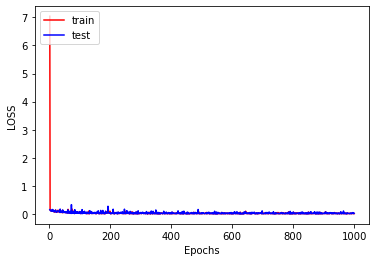

In [97]:

# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The next graphic shows how the accuracy grows, and approaches the value of 1.

It shows that the model has a fairly rapid growth. Looks like gets an accuracy above 70 near of the apoch 50. Then varies between 1 and 0.8. But it has a great result.

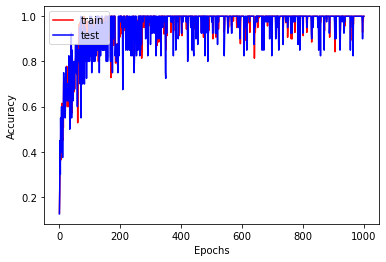

In [98]:
# plot accuracy
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
#predict
predictions_targets = model.predict(input_validation)
predicted = label_encoder.inverse_transform(predictions_targets.argmax(1))

In [100]:
# target
targets_val = label_encoder.inverse_transform(np.array(target_validation.values).argmax(1))

In [101]:
# compare them
df = pd.DataFrame({'target':targets_val, 'predicted': predicted})
df

,target,predicted
0,1,1
1,1,1
2,5,5
3,3,3
4,3,3
5,3,3
6,3,3
7,3,3
8,3,3
9,1,1


With this table we can see the predicts, and we can see only one mistake. Looks like the actiavion method of "sigmoid" has better results that the actiavion method of "relu". So i made another test using only the actiavion method of "sigmoid".

## Train Neural Network 2


A second try using only actiavion method of "sigmoid"

In [102]:

# neural network
model = models.Sequential()

# input layer
model.add(layers.Dense(64, activation='sigmoid', input_shape=(6,)))

# hidden layers
model.add(layers.Dense(32, activation='sigmoid'))

# output layers
model.add(layers.Dense(6))
    
rmsprop = optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=rmsprop, loss='mse', metrics=[metrics.categorical_accuracy])

In [103]:
num_epochs = 1000
batch_size = 64

history = model.fit(input_training, target_training,
                            validation_data=(input_test, target_test),
                            epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/1000
3/3 [==============================] - 0s 58ms/step - loss: 9.7714 - categorical_accuracy: 0.1429 - val_loss: 0.2554 - val_categorical_accuracy: 0.1250
Epoch 2/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.1968 - categorical_accuracy: 0.1500 - val_loss: 0.1439 - val_categorical_accuracy: 0.1750
Epoch 3/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.1479 - categorical_accuracy: 0.1286 - val_loss: 0.1455 - val_categorical_accuracy: 0.1750
Epoch 4/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.1464 - categorical_accuracy: 0.1429 - val_loss: 0.1427 - val_categorical_accuracy: 0.2000
Epoch 5/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.1455 - categorical_accuracy: 0.1500 - val_loss: 0.1495 - val_categorical_accuracy: 0.1750
Epoch 6/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.1498 - categorical_accuracy: 0.1429 - val_loss: 0.1570 - val_categorical_accuracy: 0.1750
Epoch 7/10

3/3 [==============================] - 0s 9ms/step - loss: 0.0635 - categorical_accuracy: 0.7500 - val_loss: 0.0850 - val_categorical_accuracy: 0.6750
Epoch 51/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0855 - categorical_accuracy: 0.6000 - val_loss: 0.0684 - val_categorical_accuracy: 0.6750
Epoch 52/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0589 - categorical_accuracy: 0.7143 - val_loss: 0.0594 - val_categorical_accuracy: 0.7500
Epoch 53/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0633 - categorical_accuracy: 0.7071 - val_loss: 0.1114 - val_categorical_accuracy: 0.5750
Epoch 54/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0912 - categorical_accuracy: 0.6571 - val_loss: 0.0659 - val_categorical_accuracy: 0.6750
Epoch 55/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0640 - categorical_accuracy: 0.6429 - val_loss: 0.0763 - val_categorical_accuracy: 0.6000
Epoch 56/1000
3/3 [====

3/3 [==============================] - 0s 9ms/step - loss: 0.0202 - categorical_accuracy: 0.9571 - val_loss: 0.0209 - val_categorical_accuracy: 1.0000
Epoch 100/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0182 - categorical_accuracy: 1.0000 - val_loss: 0.0240 - val_categorical_accuracy: 0.9750
Epoch 101/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0293 - categorical_accuracy: 0.9429 - val_loss: 0.0866 - val_categorical_accuracy: 0.7500
Epoch 102/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0785 - categorical_accuracy: 0.7500 - val_loss: 0.0460 - val_categorical_accuracy: 0.9000
Epoch 103/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0399 - categorical_accuracy: 0.9286 - val_loss: 0.0460 - val_categorical_accuracy: 0.8250
Epoch 104/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0316 - categorical_accuracy: 0.8571 - val_loss: 0.0356 - val_categorical_accuracy: 0.8750
Epoch 105/1000
3

Epoch 148/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0118 - categorical_accuracy: 0.9786 - val_loss: 0.0602 - val_categorical_accuracy: 0.8500
Epoch 149/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0581 - categorical_accuracy: 0.8929 - val_loss: 0.0336 - val_categorical_accuracy: 0.9250
Epoch 150/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0376 - categorical_accuracy: 0.8786 - val_loss: 0.0106 - val_categorical_accuracy: 1.0000
Epoch 151/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0098 - categorical_accuracy: 0.9929 - val_loss: 0.0158 - val_categorical_accuracy: 1.0000
Epoch 152/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0142 - categorical_accuracy: 1.0000 - val_loss: 0.0374 - val_categorical_accuracy: 0.9250
Epoch 153/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0523 - categorical_accuracy: 0.8500 - val_loss: 0.1585 - val_categorical_accuracy: 0.7000
E

Epoch 197/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0195 - categorical_accuracy: 0.9786 - val_loss: 0.0291 - val_categorical_accuracy: 1.0000
Epoch 198/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0247 - categorical_accuracy: 0.9929 - val_loss: 0.0178 - val_categorical_accuracy: 0.9750
Epoch 199/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0217 - categorical_accuracy: 0.9786 - val_loss: 0.0828 - val_categorical_accuracy: 0.8000
Epoch 200/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0429 - categorical_accuracy: 0.8786 - val_loss: 0.0141 - val_categorical_accuracy: 0.9750
Epoch 201/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0188 - categorical_accuracy: 0.9357 - val_loss: 0.0224 - val_categorical_accuracy: 0.9500
Epoch 202/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0154 - categorical_accuracy: 1.0000 - val_loss: 0.0309 - val_categorical_accuracy: 1.000

3/3 [==============================] - 0s 13ms/step - loss: 0.0128 - categorical_accuracy: 0.9857 - val_loss: 0.0262 - val_categorical_accuracy: 0.9250
Epoch 247/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0180 - categorical_accuracy: 1.0000 - val_loss: 0.0307 - val_categorical_accuracy: 0.9750
Epoch 248/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0191 - categorical_accuracy: 1.0000 - val_loss: 0.0147 - val_categorical_accuracy: 0.9500
Epoch 249/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0203 - categorical_accuracy: 0.9429 - val_loss: 0.0231 - val_categorical_accuracy: 0.9250
Epoch 250/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0110 - categorical_accuracy: 0.9929 - val_loss: 0.0100 - val_categorical_accuracy: 1.0000
Epoch 251/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0063 - categorical_accuracy: 1.0000 - val_loss: 0.0137 - val_categorical_accuracy: 1.0000
Epoch 252/100

3/3 [==============================] - 0s 10ms/step - loss: 0.0175 - categorical_accuracy: 0.9857 - val_loss: 0.0673 - val_categorical_accuracy: 0.8500
Epoch 296/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0267 - categorical_accuracy: 0.9357 - val_loss: 0.0169 - val_categorical_accuracy: 0.9750
Epoch 297/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0089 - categorical_accuracy: 0.9929 - val_loss: 0.0177 - val_categorical_accuracy: 1.0000
Epoch 298/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0161 - categorical_accuracy: 1.0000 - val_loss: 0.0130 - val_categorical_accuracy: 0.9750
Epoch 299/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0067 - categorical_accuracy: 1.0000 - val_loss: 0.0096 - val_categorical_accuracy: 1.0000
Epoch 300/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0105 - categorical_accuracy: 1.0000 - val_loss: 0.0263 - val_categorical_accuracy: 1.0000
Epoch 301/100

3/3 [==============================] - 0s 10ms/step - loss: 0.0265 - categorical_accuracy: 0.9929 - val_loss: 0.0266 - val_categorical_accuracy: 0.9250
Epoch 345/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0180 - categorical_accuracy: 0.9714 - val_loss: 0.0281 - val_categorical_accuracy: 0.9500
Epoch 346/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0142 - categorical_accuracy: 0.9929 - val_loss: 0.0251 - val_categorical_accuracy: 0.9500
Epoch 347/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0279 - categorical_accuracy: 0.9286 - val_loss: 0.0272 - val_categorical_accuracy: 0.9000
Epoch 348/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0120 - categorical_accuracy: 0.9857 - val_loss: 0.0236 - val_categorical_accuracy: 0.9750
Epoch 349/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0204 - categorical_accuracy: 0.9857 - val_loss: 0.0113 - val_categorical_accuracy: 0.9750
Epoch 350/100

3/3 [==============================] - 0s 11ms/step - loss: 0.0223 - categorical_accuracy: 1.0000 - val_loss: 0.0077 - val_categorical_accuracy: 0.9750
Epoch 394/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0137 - categorical_accuracy: 0.9500 - val_loss: 0.1128 - val_categorical_accuracy: 0.8250
Epoch 395/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0421 - categorical_accuracy: 0.9571 - val_loss: 0.0236 - val_categorical_accuracy: 0.9750
Epoch 396/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0118 - categorical_accuracy: 0.9929 - val_loss: 0.0075 - val_categorical_accuracy: 0.9750
Epoch 397/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0059 - categorical_accuracy: 0.9929 - val_loss: 0.0126 - val_categorical_accuracy: 1.0000
Epoch 398/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0189 - categorical_accuracy: 1.0000 - val_loss: 0.0227 - val_categorical_accuracy: 1.0000
Epoch 399/1000


3/3 [==============================] - 0s 9ms/step - loss: 0.0154 - categorical_accuracy: 1.0000 - val_loss: 0.0096 - val_categorical_accuracy: 1.0000
Epoch 443/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0085 - categorical_accuracy: 1.0000 - val_loss: 0.0350 - val_categorical_accuracy: 0.9250
Epoch 444/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0223 - categorical_accuracy: 1.0000 - val_loss: 0.0236 - val_categorical_accuracy: 0.9750
Epoch 445/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0206 - categorical_accuracy: 1.0000 - val_loss: 0.0483 - val_categorical_accuracy: 0.9250
Epoch 446/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0453 - categorical_accuracy: 0.9143 - val_loss: 0.0110 - val_categorical_accuracy: 1.0000
Epoch 447/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0071 - categorical_accuracy: 1.0000 - val_loss: 0.0033 - val_categorical_accuracy: 1.0000
Epoch 448/1000

Epoch 491/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0242 - categorical_accuracy: 0.9643 - val_loss: 0.0985 - val_categorical_accuracy: 0.8500
Epoch 492/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0520 - categorical_accuracy: 0.9357 - val_loss: 0.0120 - val_categorical_accuracy: 1.0000
Epoch 493/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0100 - categorical_accuracy: 1.0000 - val_loss: 0.0081 - val_categorical_accuracy: 1.0000
Epoch 494/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0083 - categorical_accuracy: 1.0000 - val_loss: 0.0029 - val_categorical_accuracy: 1.0000
Epoch 495/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0034 - categorical_accuracy: 1.0000 - val_loss: 0.0100 - val_categorical_accuracy: 1.0000
Epoch 496/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0121 - categorical_accuracy: 1.0000 - val_loss: 0.0197 - val_categorical_accuracy: 1.0000

3/3 [==============================] - 0s 10ms/step - loss: 0.0094 - categorical_accuracy: 1.0000 - val_loss: 0.0577 - val_categorical_accuracy: 0.9250
Epoch 541/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0721 - categorical_accuracy: 0.9071 - val_loss: 0.0130 - val_categorical_accuracy: 1.0000
Epoch 542/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0063 - categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_categorical_accuracy: 1.0000
Epoch 543/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.0061 - val_categorical_accuracy: 1.0000
Epoch 544/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0091 - categorical_accuracy: 1.0000 - val_loss: 0.0213 - val_categorical_accuracy: 1.0000
Epoch 545/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0205 - categorical_accuracy: 1.0000 - val_loss: 0.0124 - val_categorical_accuracy: 1.0000
Epoch 546/1000

3/3 [==============================] - 0s 10ms/step - loss: 0.0148 - categorical_accuracy: 0.9786 - val_loss: 0.0215 - val_categorical_accuracy: 1.0000
Epoch 590/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0165 - categorical_accuracy: 1.0000 - val_loss: 0.0182 - val_categorical_accuracy: 1.0000
Epoch 591/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0189 - categorical_accuracy: 1.0000 - val_loss: 0.0306 - val_categorical_accuracy: 1.0000
Epoch 592/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0255 - categorical_accuracy: 0.9929 - val_loss: 0.0100 - val_categorical_accuracy: 0.9750
Epoch 593/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0149 - categorical_accuracy: 0.9571 - val_loss: 0.0079 - val_categorical_accuracy: 0.9750
Epoch 594/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0065 - categorical_accuracy: 0.9857 - val_loss: 0.0040 - val_categorical_accuracy: 1.0000
Epoch 595/1000

Epoch 638/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0210 - categorical_accuracy: 1.0000 - val_loss: 0.0166 - val_categorical_accuracy: 1.0000
Epoch 639/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0176 - categorical_accuracy: 0.9857 - val_loss: 0.0834 - val_categorical_accuracy: 0.8500
Epoch 640/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0359 - categorical_accuracy: 0.9786 - val_loss: 0.0079 - val_categorical_accuracy: 1.0000
Epoch 641/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.0042 - val_categorical_accuracy: 1.0000
Epoch 642/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 0.0056 - val_categorical_accuracy: 1.0000
Epoch 643/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0073 - categorical_accuracy: 1.0000 - val_loss: 0.0215 - val_categorical_accuracy: 1.000

3/3 [==============================] - 0s 11ms/step - loss: 0.0500 - categorical_accuracy: 0.9429 - val_loss: 0.0044 - val_categorical_accuracy: 1.0000
Epoch 688/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0047 - categorical_accuracy: 1.0000 - val_loss: 0.0036 - val_categorical_accuracy: 1.0000
Epoch 689/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0045 - categorical_accuracy: 1.0000 - val_loss: 0.0074 - val_categorical_accuracy: 1.0000
Epoch 690/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0067 - categorical_accuracy: 1.0000 - val_loss: 0.0138 - val_categorical_accuracy: 1.0000
Epoch 691/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0198 - categorical_accuracy: 1.0000 - val_loss: 0.0390 - val_categorical_accuracy: 0.9250
Epoch 692/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0319 - categorical_accuracy: 0.9643 - val_loss: 0.0438 - val_categorical_accuracy: 0.8750
Epoch 693/100

3/3 [==============================] - 0s 10ms/step - loss: 0.0187 - categorical_accuracy: 1.0000 - val_loss: 0.0141 - val_categorical_accuracy: 0.9750
Epoch 737/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0106 - categorical_accuracy: 0.9929 - val_loss: 0.0405 - val_categorical_accuracy: 0.9250
Epoch 738/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0418 - categorical_accuracy: 0.9143 - val_loss: 0.0048 - val_categorical_accuracy: 1.0000
Epoch 739/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0042 - categorical_accuracy: 1.0000 - val_loss: 0.0179 - val_categorical_accuracy: 1.0000
Epoch 740/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0227 - categorical_accuracy: 1.0000 - val_loss: 0.0118 - val_categorical_accuracy: 1.0000
Epoch 741/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0097 - categorical_accuracy: 1.0000 - val_loss: 0.0066 - val_categorical_accuracy: 1.0000
Epoch 742/1000

3/3 [==============================] - 0s 10ms/step - loss: 0.0042 - categorical_accuracy: 1.0000 - val_loss: 0.0027 - val_categorical_accuracy: 1.0000
Epoch 786/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0037 - categorical_accuracy: 1.0000 - val_loss: 0.0129 - val_categorical_accuracy: 1.0000
Epoch 787/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0146 - categorical_accuracy: 1.0000 - val_loss: 0.0087 - val_categorical_accuracy: 1.0000
Epoch 788/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0104 - categorical_accuracy: 1.0000 - val_loss: 0.0278 - val_categorical_accuracy: 1.0000
Epoch 789/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0273 - categorical_accuracy: 1.0000 - val_loss: 0.0117 - val_categorical_accuracy: 1.0000
Epoch 790/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0105 - categorical_accuracy: 0.9929 - val_loss: 0.0038 - val_categorical_accuracy: 1.0000
Epoch 791/1000


3/3 [==============================] - 0s 10ms/step - loss: 0.0115 - categorical_accuracy: 1.0000 - val_loss: 0.0275 - val_categorical_accuracy: 1.0000
Epoch 835/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0286 - categorical_accuracy: 1.0000 - val_loss: 0.0245 - val_categorical_accuracy: 1.0000
Epoch 836/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0128 - categorical_accuracy: 1.0000 - val_loss: 0.0066 - val_categorical_accuracy: 1.0000
Epoch 837/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.0132 - val_categorical_accuracy: 1.0000
Epoch 838/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0151 - categorical_accuracy: 1.0000 - val_loss: 0.0135 - val_categorical_accuracy: 1.0000
Epoch 839/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0151 - categorical_accuracy: 1.0000 - val_loss: 0.0106 - val_categorical_accuracy: 1.0000
Epoch 840/1000
3

Epoch 883/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0110 - categorical_accuracy: 1.0000 - val_loss: 0.0134 - val_categorical_accuracy: 1.0000
Epoch 884/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0155 - categorical_accuracy: 0.9929 - val_loss: 0.0132 - val_categorical_accuracy: 0.9750
Epoch 885/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0128 - categorical_accuracy: 0.9857 - val_loss: 0.0317 - val_categorical_accuracy: 0.9750
Epoch 886/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0254 - categorical_accuracy: 1.0000 - val_loss: 0.0173 - val_categorical_accuracy: 1.0000
Epoch 887/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0153 - categorical_accuracy: 1.0000 - val_loss: 0.0057 - val_categorical_accuracy: 1.0000
Epoch 888/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - categorical_accuracy: 1.0000 - val_loss: 0.0136 - val_categorical_accuracy: 1.000

3/3 [==============================] - 0s 11ms/step - loss: 0.0555 - categorical_accuracy: 0.9214 - val_loss: 0.0272 - val_categorical_accuracy: 0.9750
Epoch 933/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0235 - categorical_accuracy: 1.0000 - val_loss: 0.0057 - val_categorical_accuracy: 1.0000
Epoch 934/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0038 - categorical_accuracy: 1.0000 - val_loss: 0.0021 - val_categorical_accuracy: 1.0000
Epoch 935/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.0072 - val_categorical_accuracy: 1.0000
Epoch 936/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - categorical_accuracy: 1.0000 - val_loss: 0.0088 - val_categorical_accuracy: 1.0000
Epoch 937/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0094 - categorical_accuracy: 1.0000 - val_loss: 0.0340 - val_categorical_accuracy: 1.0000
Epoch 938/100

3/3 [==============================] - 0s 11ms/step - loss: 0.0141 - categorical_accuracy: 1.0000 - val_loss: 0.0063 - val_categorical_accuracy: 1.0000
Epoch 982/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0086 - categorical_accuracy: 1.0000 - val_loss: 0.0179 - val_categorical_accuracy: 1.0000
Epoch 983/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0182 - categorical_accuracy: 1.0000 - val_loss: 0.0069 - val_categorical_accuracy: 1.0000
Epoch 984/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0065 - categorical_accuracy: 1.0000 - val_loss: 0.0105 - val_categorical_accuracy: 1.0000
Epoch 985/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0147 - categorical_accuracy: 1.0000 - val_loss: 0.0125 - val_categorical_accuracy: 1.0000
Epoch 986/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0102 - categorical_accuracy: 1.0000 - val_loss: 0.0077 - val_categorical_accuracy: 1.0000
Epoch 987/100

Finally the train ends with an accuracy of 1, and the loss is 0.0167. The previous epoch looks similar, so it looks like a good train.

In [104]:
epochs = range(1, num_epochs+1)

# during training
loss = history.history['loss']
accuracy = history.history['categorical_accuracy']

# outside training
val_loss = history.history['val_loss']
val_accuracy = history.history['val_categorical_accuracy']

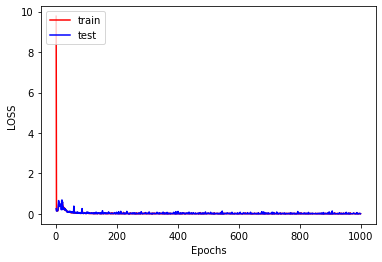

In [105]:
# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

With this graphic we can take sure that is better the actiavion method of "sigmoid" in this case. The highest value of loss is at the beginning, and is always below 1.

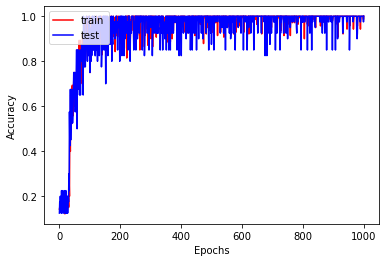

In [106]:
# plot accuracy
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Talking about accuracy, looks very similar to the previous test. So we can only differentiate it in that this model will have less mistakes than the previous.

In [107]:
#predict
predictions_targets = model.predict(input_validation)
predicted = label_encoder.inverse_transform(predictions_targets.argmax(1))

In [108]:
# target
targets_val = label_encoder.inverse_transform(np.array(target_validation.values).argmax(1))

In [109]:
# compare them
df = pd.DataFrame({'target':targets_val, 'predicted': predicted})
df

,target,predicted
0,1,1
1,1,1
2,5,5
3,3,3
4,3,3
5,3,3
6,3,4
7,3,3
8,3,3
9,1,1


The predics with the training examples looks very similar than the previous model. So it only remains to test the model.

## Predicted Results

First of all, I normalize the data, so the neural network can predict just like i trained before. 

In [110]:
csv_file_test = 'test_ds.csv'
df_test = pd.read_csv(csv_file_test)
df_test[0:10]

,Temperature,L,R,A_M,Color,Spectral_Class
0,21020,0.00150,0.0112,11.52,Blue,B
1,2935,0.00087,0.0932,16.88,Red,M
2,16390,1278.00000,5.6800,-3.32,Blue-white,B
3,3628,0.00550,0.3930,10.48,Red,M
4,3496,0.00125,0.3360,14.94,Red,M
5,3342,0.00150,0.3070,11.87,Red,M
6,17140,883.00000,5.6530,-2.64,Blue-white,B
7,24490,248490.00000,1134.5000,-8.24,Blue-white,B
8,11000,170000.00000,1779.0000,-9.90,Blue-white,B
9,24020,0.00159,0.0127,10.55,Blue,B


In [111]:
print(df_test.shape)
print(df_test['Color'].unique())
print(df_test['Spectral_Class'].unique())

(39, 6)
['Blue' 'Red' 'Blue-white' 'Whitish' 'white']
['B' 'M' 'O' 'F']


In [112]:
df_test.Color = df_test["Color"].str.upper()

df_test['Color'] = df_test['Color'].map({'RED':1,
                             'BLUE-WHITE':2,
                             'BLUE WHITE':2,
                             'BLUE':3,
                             'WHITISH':4,
                             'WHITE':5,
                             'YELLOWISH':6,
                             'YELLOW-WHITE':7,
                             'WHITE-YELLOW':7,
                             'YELLOWISH WHITE':8,
                             'ORANGE':9,
                             'PALE YELLOW ORANGE':10,
                             'ORANGE-RED':11},
                             na_action=None)

df_test['Spectral_Class'] = df_test['Spectral_Class'].map({'M':1,
                             'A':2,
                             'O':3,
                             'B':4,
                             'K':5,
                             'F':6,
                             'G':7},
                             na_action=None)

print(df_test)

    Temperature             L           R     A_M  Color  Spectral_Class
0         21020       0.00150     0.01120  11.520      3               4
1          2935       0.00087     0.09320  16.880      1               1
2         16390    1278.00000     5.68000  -3.320      2               4
3          3628       0.00550     0.39300  10.480      1               1
4          3496       0.00125     0.33600  14.940      1               1
5          3342       0.00150     0.30700  11.870      1               1
6         17140     883.00000     5.65300  -2.640      2               4
7         24490  248490.00000  1134.50000  -8.240      2               4
8         11000  170000.00000  1779.00000  -9.900      2               4
9         24020       0.00159     0.01270  10.550      3               4
10        23678  244290.00000    35.00000  -6.270      3               3
11        16790       0.00140     0.01210  12.870      3               4
12         9700      74.00000     2.89000   0.160  

In [113]:
test = df_test[['Temperature','L','R','A_M','Color','Spectral_Class']]

In [114]:
# scale input data
x = test.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test = pd.DataFrame(x_scaled)
test

,0,1,2,3,4,5
0,0.599347,1.816992e-09,0.000001,0.726248,0.50,0.6
1,0.009299,9.752969e-10,0.000047,0.898873,0.00,0.0
2,0.448287,1.707437e-03,0.003188,0.248309,0.25,0.6
3,0.031909,7.161084e-09,0.000216,0.692754,0.00,0.0
4,0.027602,1.482986e-09,0.000184,0.836393,0.00,0.0
5,0.022577,1.816992e-09,0.000168,0.737520,0.00,0.0
6,0.472757,1.179708e-03,0.003173,0.270209,0.25,0.6
7,0.712561,3.319884e-01,0.637716,0.089855,0.25,0.6
8,0.272431,2.271239e-01,1.000000,0.036393,0.25,0.6
9,0.697227,1.937234e-09,0.000002,0.695008,0.50,0.6


Now, the moment of truth. Time to predict

In [115]:
prediccted_results = model.predict(test)

In [116]:
prediccted_result = np.argmax(np.round(prediccted_results),axis=1)

In [117]:
for i in range(39):
    print("id: ",i, " ",prediccted_result[i])

id:  0   2
id:  1   0
id:  2   3
id:  3   1
id:  4   1
id:  5   1
id:  6   3
id:  7   5
id:  8   5
id:  9   2
id:  10   4
id:  11   2
id:  12   3
id:  13   0
id:  14   0
id:  15   4
id:  16   2
id:  17   5
id:  18   1
id:  19   4
id:  20   0
id:  21   5
id:  22   4
id:  23   4
id:  24   0
id:  25   1
id:  26   0
id:  27   5
id:  28   3
id:  29   4
id:  30   3
id:  31   3
id:  32   0
id:  33   5
id:  34   0
id:  35   1
id:  36   4
id:  37   0
id:  38   0


In [118]:
handler = open('predicted_results.csv', 'w')
handler.write('Id,Type'+ '\n')
for i in range(39):
    var = str(i+1) + ","+ str(prediccted_result[i])
    handler.write(var+ '\n')
handler.close()
handler = open('predicted_results.csv', 'r')
handler.read()

'Id,Type\n1,2\n2,0\n3,3\n4,1\n5,1\n6,1\n7,3\n8,5\n9,5\n10,2\n11,4\n12,2\n13,3\n14,0\n15,0\n16,4\n17,2\n18,5\n19,1\n20,4\n21,0\n22,5\n23,4\n24,4\n25,0\n26,1\n27,0\n28,5\n29,3\n30,4\n31,3\n32,3\n33,0\n34,5\n35,0\n36,1\n37,4\n38,0\n39,0\n'

Finally i saved the predicts into a file named 'predicted_results.csv'. But the  results were showed before. 

## Random Forest

A decision tree allows establishing a series of tests or conditionals that lead to an output from the input characteristics

Disadvantages
biases in the models
They have difficulty representing the objective function well
They present high variance

That is why we study this random forest model.
A random forest is an assembly of several decision trees.

In the random forest model, the aim is to divide the dataset into sections that are distributed in the decision trees, in addition, some characteristics will be used for each tree.
In other words, each tree will have a data subset with dimensions smaller than the original dataset.
For each of these trees, a model will be established, which will be built from these data subset.
Before a particular input, each of the decision trees will produce a classification or regression result.

The way to decide which will be the output of the assembly will be by applying the majority rule for the classification systems.

In [119]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [121]:
#Charge Dataset
inputs

,0,1,2,3,4,5
0,0.039778,6.369052e-10,3.536069e-05,0.906817,0.0,0.000000
1,0.266914,8.111416e-04,3.593344e-03,0.373358,0.1,0.166667
2,0.020809,4.202868e-10,3.962039e-05,0.938399,0.0,0.000000
3,0.942198,2.388689e-01,3.516361e-03,0.230144,0.2,0.333333
4,0.174220,8.594100e-10,6.671828e-07,0.816760,0.1,0.166667
...,...,...,...,...,...,...
195,0.301647,6.004097e-10,7.236367e-07,0.800188,0.1,0.500000
196,0.470849,1.200819e-09,2.412122e-06,0.727330,0.2,0.500000
197,0.291217,1.174919e-03,3.182770e-03,0.329581,0.1,0.166667
198,0.973726,2.401639e-01,5.435795e-03,0.225766,0.2,0.333333


In [151]:
print(df_train)

     Temperature              L         R    A_M  Color  Spectral_Class  Type
0           3453       0.000621   0.07730  17.08      1               1     0
1          12098     689.000000   7.01000   0.02      2               2     3
2           2731       0.000437   0.08560  18.09      1               1     0
3          37800  202900.000000   6.86000  -4.56      3               3     3
4           8570       0.000810   0.00970  14.20      2               2     2
..           ...            ...       ...    ...    ...             ...   ...
195        13420       0.000590   0.00981  13.67      2               4     2
196        19860       0.001100   0.01310  11.34      3               4     2
197        13023     998.000000   6.21000  -1.38      2               2     3
198        39000  204000.000000  10.60000  -4.70      3               3     3
199        12010       0.000780   0.00920  12.13      2               4     2

[200 rows x 7 columns]


In [137]:
# I divide the data into training and testing
from sklearn.model_selection import train_test_split
# X are our independent variables
X = df_train.drop(["Type"],axis = 1)

# y is our dependent variable
y = df_train.Type

# 75% data division for training, 25% data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [138]:
# I create the Random Forest model (and configure the number of estimators (decision trees))
BA_model = RandomForestClassifier(n_estimators = 19, 
                                  random_state = 2016,
                                  min_samples_leaf = 8,)

In [139]:
BA_model.fit(X_train, y_train)

D:\Anaconda\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
D:\Anaconda\Anaconda\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=2016,
                       verbose=0, warm_start=False)

In [140]:
# Average Accuracy
BA_model.score(X_test, y_test)

D:\Anaconda\Anaconda\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


1.0

D:\Anaconda\Anaconda\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


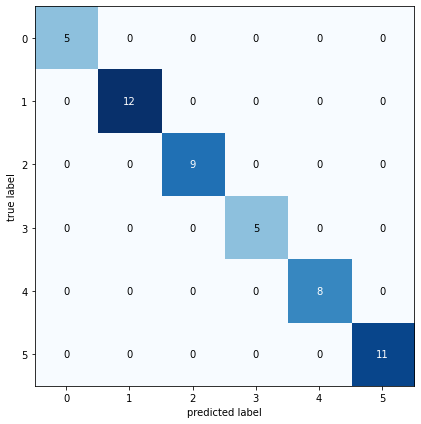

In [142]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Model prediction using the test data
y_pred = BA_model.predict(X_test)
matriz = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plt.tight_layout()

In the The matrix shows how many predictions were correctly given, the ramdon forest model has a perfecly accuracy, so all the values are on the diagonal. This model looks good, so for this sample, is a good option. 

So, we create another answers with this model, then i compared the answers of both models.

In [145]:
predicted_test = BA_model.predict(df_test)

D:\Anaconda\Anaconda\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [146]:
predicted_test

array([2, 0, 3, 1, 1, 1, 3, 5, 5, 2, 4, 2, 3, 0, 0, 4, 2, 5, 1, 4, 1, 5,
       4, 4, 0, 1, 0, 5, 3, 4, 3, 3, 0, 5, 0, 1, 4, 0, 0], dtype=int64)

In [152]:
for i in range(39):
    print("id: ",i+1, " ",predicted_test[i], " ", prediccted_result[i])

id:  1   2   2
id:  2   0   0
id:  3   3   3
id:  4   1   1
id:  5   1   1
id:  6   1   1
id:  7   3   3
id:  8   5   5
id:  9   5   5
id:  10   2   2
id:  11   4   4
id:  12   2   2
id:  13   3   3
id:  14   0   0
id:  15   0   0
id:  16   4   4
id:  17   2   2
id:  18   5   5
id:  19   1   1
id:  20   4   4
id:  21   1   0
id:  22   5   5
id:  23   4   4
id:  24   4   4
id:  25   0   0
id:  26   1   1
id:  27   0   0
id:  28   5   5
id:  29   3   3
id:  30   4   4
id:  31   3   3
id:  32   3   3
id:  33   0   0
id:  34   5   5
id:  35   0   0
id:  36   1   1
id:  37   4   4
id:  38   0   0
id:  39   0   0


With this comparative, only the id 21 looks diferent. So we can take sure that both answers are good. It only remains to verify the real answers of the tados of the final test

In [150]:
handler = open('predicted_results.csv', 'w')
handler.write('Id,Type'+ '\n')
for i in range(39):
    var = str(i+1) + ","+ str(predicted_test[i])
    handler.write(var+ '\n')
handler.close()
handler = open('predicted_results.csv', 'r')
handler.read()

'Id,Type\n1,2\n2,0\n3,3\n4,1\n5,1\n6,1\n7,3\n8,5\n9,5\n10,2\n11,4\n12,2\n13,3\n14,0\n15,0\n16,4\n17,2\n18,5\n19,1\n20,4\n21,1\n22,5\n23,4\n24,4\n25,0\n26,1\n27,0\n28,5\n29,3\n30,4\n31,3\n32,3\n33,0\n34,5\n35,0\n36,1\n37,4\n38,0\n39,0\n'